# Aid & Alliance 

Aid & Alliance is a flagship mutual aid and resource sharing program designed to distribute nearly $500,000 in mutual aid funds to BIPOC organizers and activists across the country as March For Our Lives celebrates the three-year anniversary of the historic march to end gun violence. Through the program, MFOL chapters nationwide will be able to engage in mutual aid at the community level, and organizations in select cities will be able to apply for grant funds directly from the national organization for anti-gun violence work.

When designing the cities track, we knew that we needed to limit the number of cities that we open the program to 8. This was both an impact and a capacity decision -- with limited funds, we wanted to make sure that the size of the grants were useful to organizations and we wanted to ensure that we had the people power to manage distribution, process, and reporting. In order to select the cities in which we open the program to, I designed a custom index based on stakeholder input to rank cities across the country and give decision makers a stronger sense of ordinality of need. The final decision on which cities to include was made using the insights from this index. 

### Process

For more information on the stakeholder input and organizational context for the program, you can check out [this blog post on LinkedIn.](https://www.linkedin.com/pulse/data-march-our-lives-how-we-picked-target-cities-mutual-tej-gokhale) A quick summary that to build this index, I took the following process:

1. [**Factor Selection:**](#factor_selection) Stakeholders weighed in on the most important factors to consider in cities.
2. [**Data Aggregation & Cleaning:**](#data_munging) I hunted for the best sources that we could use to measure each of those factors. Then I cleaned the data up to make it ready for index building.
3. [**Factor Normalization:**](#factor_normalization) I used min-max normalization to scale all the factors to a value between 0 and 1.
4. [**Index Building:**](#index_building) I multiplied each factor by its relative importance to stakeholders and then cleaned up any cities that spanned multiple counties or cities that were in the same county. 
5. [**Conclusion:**](#conclusion) Building the list based on what the index revealed. 

A note that we're only looking at the top 200 cities in the United States by population to make this index. This is in pursuit of choosing cities that are impactful and that we're likely to have a chapter ("boots on the ground") presence in. 

**A quick visual representation of this whole process:**

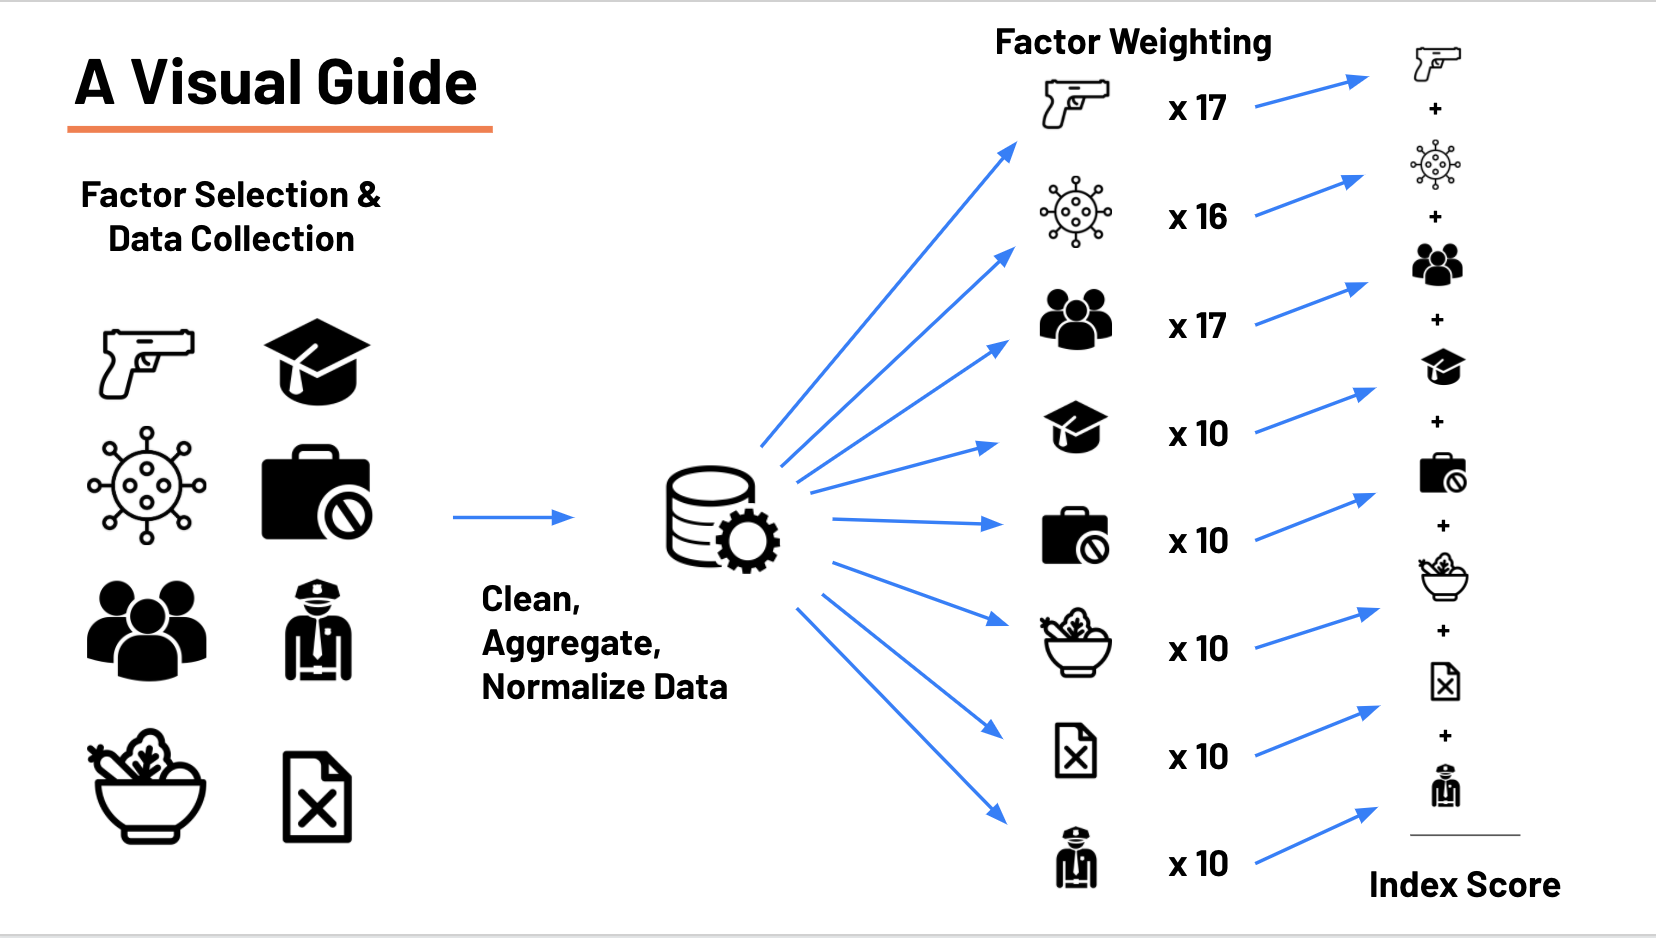

### Sources
For more information on the sources of the data, you can [check the README on Github.](https://github.com/March-For-Our-Lives/aid-alliance/blob/main/index/README.md)

<a id='factor_selection'></a>

# Factor Selection

Stakeholders chose the following factors for this index:
- Gun Deaths
- COVID Cases
- BIPOC Youth Population
- Food Insecurity
- Police Violence (deaths at the hands of police)
- Undocumented Immigrant Population
- Unemployment
- Education

In [1]:
import requests
import io
from io import StringIO
import pandas as pd
import zipfile

# Github URLs
food_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/food_insecurity.csv'
police_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/police_killings.csv'
ed_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/education.csv'
undocu_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/undocumented_immigrants.csv'
covid_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/covid.csv'
unemploy_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/unemployment.csv'
gun_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/gun_deaths.csv'
county_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/county_fips_master_fixed.csv'
cities_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/uscities.csv'
cities_counties_url = 'https://raw.githubusercontent.com/March-For-Our-Lives/aid-alliance/main/index/data/cities_spanning_counties.csv'
bipoc_url = 'https://github.com/March-For-Our-Lives/aid-alliance/blob/main/index/data/bipoc.csv.zip?raw=true'

# Requests to grab files
food_down = requests.get(food_url).content
police_down = requests.get(police_url).content
ed_down = requests.get(ed_url).content
undocu_down = requests.get(undocu_url).content
covid_down = requests.get(covid_url).content
unemploy_down = requests.get(unemploy_url).content
gun_down = requests.get(gun_url).content
county_down = requests.get(county_url).content
cities_down = requests.get(cities_url).content
cities_counties_down = requests.get(cities_counties_url).content
# BIPOC is a zip file so requires a special implementation
bipoc_down = requests.get(bipoc_url)
zipper = zipfile.ZipFile(io.BytesIO(bipoc_down.content))

# Creating dataframes

# Index factor datasets
food_insecurity = pd.read_csv(io.StringIO(food_down.decode('utf-8'))) #2018, 2020
police_killings = pd.read_csv(io.StringIO(police_down.decode('utf-8'))) #All years
education = pd.read_csv(io.StringIO(ed_down.decode('utf-8'))) #2018
undocu = pd.read_csv(io.StringIO(undocu_down.decode('utf-8'))) #2018
covid = pd.read_csv(io.StringIO(covid_down.decode('utf-8'))) #2020
bipoc = pd.read_csv(zipper.open('bipoc.csv')) #2018
unemployment = pd.read_csv(io.StringIO(unemploy_down.decode('utf-8'))) #All years
gun = pd.read_csv(io.StringIO(gun_down.decode('utf-8'))) #2018, 2019

# Supporter datasets - not factors, but helps with merging into one frame and filtering to top cities.
county_codes = pd.read_csv(io.StringIO(county_down.decode('utf-8')))
cities = pd.read_csv(io.StringIO(cities_down.decode('utf-8')))
cities_spanning_counties = pd.read_csv(io.StringIO(cities_counties_down.decode('utf-8')))

# This list is not used for anything beyond printing the shapes of the dataframes.
all_datasets = [food_insecurity, police_killings, education, undocu, covid, bipoc, unemployment,
               gun, county_codes, cities, cities_spanning_counties]

for data in all_datasets:
    print(data.shape)

(3142, 18)
(8779, 50)
(3283, 47)
(271, 4)
(3246, 10)
(656678, 80)
(45066, 9)
(829, 5)
(3146, 13)
(28372, 17)
(691, 3)


<a id='data_munging'></a>

# Data Munging

### County Codes

Starting off by cleaning up counties data - this will be used to help create one final dataset to create a common crosswalk between all 8 factors in the index. We'll primarily be using county FIPS codes to join all the different factors, but there may be a couple of factors that will rely on county name and state name. 

In [2]:
county_codes.head(10)

,fips,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
0,1001,Autauga County,AL,Alabama,Autauga County AL,50.0,3.0,6.0,1.0,1.0,3-6-1-1,South,East South Central
1,1003,Baldwin County,AL,Alabama,Baldwin County AL,50.0,3.0,6.0,1.0,3.0,3-6-1-3,South,East South Central
2,1005,Barbour County,AL,Alabama,Barbour County AL,50.0,3.0,6.0,1.0,5.0,3-6-1-5,South,East South Central
3,1007,Bibb County,AL,Alabama,Bibb County AL,50.0,3.0,6.0,1.0,7.0,3-6-1-7,South,East South Central
4,1009,Blount County,AL,Alabama,Blount County AL,50.0,3.0,6.0,1.0,9.0,3-6-1-9,South,East South Central
5,1011,Bullock County,AL,Alabama,Bullock County AL,50.0,3.0,6.0,1.0,11.0,3-6-1-11,South,East South Central
6,1013,Butler County,AL,Alabama,Butler County AL,50.0,3.0,6.0,1.0,13.0,3-6-1-13,South,East South Central
7,1015,Calhoun County,AL,Alabama,Calhoun County AL,50.0,3.0,6.0,1.0,15.0,3-6-1-15,South,East South Central
8,1017,Chambers County,AL,Alabama,Chambers County AL,50.0,3.0,6.0,1.0,17.0,3-6-1-17,South,East South Central
9,1019,Cherokee County,AL,Alabama,Cherokee County AL,50.0,3.0,6.0,1.0,19.0,3-6-1-19,South,East South Central


The only real problem here is the fact that if we need to merge on county and state, instead of FIPS, the county names should match those in the factor datasets. And the only instance in which these wouldn't match currently with the factor datasets is where the county name is "Baltimore City" instead of "Baltimore City County." So we need to rewrite the names where that happens. 

In [3]:
# How many counties will we need to fix?
print(county_codes[county_codes['county_name'].str.contains('city')].shape)
print(county_codes[county_codes['county_name'].str.contains('City')].shape)

(41, 13)
(7, 13)


In [4]:
# Taking a quick look at the county names that match this criteria
county_codes[county_codes['county_name'].str.contains('city')].head(50)

,fips,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
1218,24510,Baltimore city,MD,Maryland,Baltimore city MD,50.0,3.0,5.0,24.0,510.0,3-5-24-510,South,South Atlantic
1599,29510,St. Louis city,MO,Missouri,St. Louis city MO,50.0,2.0,4.0,29.0,510.0,2-4-29-510,Midwest,West North Central
2918,51510,Alexandria city,VA,Virginia,Alexandria city VA,50.0,3.0,5.0,51.0,510.0,3-5-51-510,South,South Atlantic
2919,51515,Bedford city,VA,Virginia,Bedford city VA,NaN,NaN,NaN,NaN,NaN,NA-NA-NA-NA,NaN,NaN
2920,51520,Bristol city,VA,Virginia,Bristol city VA,50.0,3.0,5.0,51.0,520.0,3-5-51-520,South,South Atlantic
2921,51530,Buena Vista city,VA,Virginia,Buena Vista city VA,50.0,3.0,5.0,51.0,530.0,3-5-51-530,South,South Atlantic
2922,51540,Charlottesville city,VA,Virginia,Charlottesville city VA,50.0,3.0,5.0,51.0,540.0,3-5-51-540,South,South Atlantic
2923,51550,Chesapeake city,VA,Virginia,Chesapeake city VA,50.0,3.0,5.0,51.0,550.0,3-5-51-550,South,South Atlantic
2924,51570,Colonial Heights city,VA,Virginia,Colonial Heights city VA,50.0,3.0,5.0,51.0,570.0,3-5-51-570,South,South Atlantic
2925,51580,Covington city,VA,Virginia,Covington city VA,50.0,3.0,5.0,51.0,580.0,3-5-51-580,South,South Atlantic


In [5]:
county_codes['county_name'] = county_codes['county_name'].apply(lambda x: x.replace('city', 'City County') if 'city' in x else x)
county_codes['long_name'] = county_codes['long_name'].apply(lambda x: x.replace('city', 'City County') if 'city' in x else x)
county_codes[county_codes['county_name'].str.contains('City')].head(50)

,fips,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
77,2110,Juneau City and Borough,AK,Alaska,Juneau City and Borough AK,50.0,4.0,9.0,2.0,110.0,4-9-2-110,West,Pacific
89,2220,Sitka City and Borough,AK,Alaska,Sitka City and Borough AK,50.0,4.0,9.0,2.0,220.0,4-9-2-220,West,Pacific
94,2275,Wrangell City and Borough,AK,Alaska,Wrangell City and Borough AK,50.0,4.0,9.0,2.0,275.0,4-9-2-275,West,Pacific
95,2282,Yakutat City and Borough,AK,Alaska,Yakutat City and Borough AK,50.0,4.0,9.0,2.0,282.0,4-9-2-282,West,Pacific
1218,24510,Baltimore City County,MD,Maryland,Baltimore City County MD,50.0,3.0,5.0,24.0,510.0,3-5-24-510,South,South Atlantic
1599,29510,St. Louis City County,MO,Missouri,St. Louis City County MO,50.0,2.0,4.0,29.0,510.0,2-4-29-510,Midwest,West North Central
1765,32510,Carson City,NV,Nevada,Carson City NV,50.0,4.0,8.0,32.0,510.0,4-8-32-510,West,Mountain
2841,51036,Charles City County,VA,Virginia,Charles City County VA,50.0,3.0,5.0,51.0,36.0,3-5-51-36,South,South Atlantic
2869,51095,James City County,VA,Virginia,James City County VA,50.0,3.0,5.0,51.0,95.0,3-5-51-95,South,South Atlantic
2918,51510,Alexandria City County,VA,Virginia,Alexandria City County VA,50.0,3.0,5.0,51.0,510.0,3-5-51-510,South,South Atlantic


### BIPOC Demographics

Jumping into cleaning up the factor datasets, we'll start with BIPOC youth population. 

In [6]:
# From above, we know that there are many rows that we'll want to filter down into one per county. Taking a quick 
# look to identify key columns - AGEGRP (age) and YEAR (year) are the two most pertinent to start with for that.
bipoc.columns

Index(['SUMLEV', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'YEAR', 'AGEGRP',
       'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE',
       'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE',
       'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE',
       'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE',
       'AAC_FEMALE', 'NAC_MALE', 'NAC_FEMALE', 'NH_MALE', 'NH_FEMALE',
       'NHWA_MALE', 'NHWA_FEMALE', 'NHBA_MALE', 'NHBA_FEMALE', 'NHIA_MALE',
       'NHIA_FEMALE', 'NHAA_MALE', 'NHAA_FEMALE', 'NHNA_MALE', 'NHNA_FEMALE',
       'NHTOM_MALE', 'NHTOM_FEMALE', 'NHWAC_MALE', 'NHWAC_FEMALE',
       'NHBAC_MALE', 'NHBAC_FEMALE', 'NHIAC_MALE', 'NHIAC_FEMALE',
       'NHAAC_MALE', 'NHAAC_FEMALE', 'NHNAC_MALE', 'NHNAC_FEMALE', 'H_MALE',
       'H_FEMALE', 'HWA_MALE', 'HWA_FEMALE', 'HBA_MALE', 'HBA_FEMALE',
       'HIA_MALE', 'HIA_FEMALE', 'HAA_MALE', 'HAA_FEMALE', 'HNA_MALE',
       'HNA_FEMALE', 'HTOM_MALE', 'HTOM_FEMALE

In [7]:
# Filtering to get "youth" from the data in our target year. According to the data dictionary, 4 & 5 for 
# column AGEGRP gets us the target range of approximately, 15-25. Column YEAR with value 11 filters down to the 
# year 2018. 

bipoc_working = bipoc[(bipoc['AGEGRP'] == 4) | (bipoc['AGEGRP'] ==5)]
bipoc_working = bipoc_working[bipoc_working['YEAR']==11]
bipoc_working.shape

(6284, 80)

In [8]:
bipoc_working.head(30)

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
194,50,1,1,Alabama,Autauga County,11,4,3755,1913,1842,...,61,68,10,7,5,4,0,2,1,3
195,50,1,1,Alabama,Autauga County,11,5,3173,1629,1544,...,43,49,6,6,2,2,2,1,1,1
403,50,1,3,Alabama,Baldwin County,11,4,12932,6398,6534,...,349,387,16,22,17,10,4,7,4,3
404,50,1,3,Alabama,Baldwin County,11,5,11108,5632,5476,...,297,244,10,17,5,12,2,3,3,3
612,50,1,5,Alabama,Barbour County,11,4,1451,759,692,...,38,22,2,6,1,3,0,0,0,2
613,50,1,5,Alabama,Barbour County,11,5,1472,871,601,...,20,15,0,1,1,0,0,0,1,3
821,50,1,7,Alabama,Bibb County,11,4,1270,683,587,...,7,12,3,3,0,1,0,0,1,1
822,50,1,7,Alabama,Bibb County,11,5,1303,767,536,...,13,9,2,1,0,0,0,0,2,0
1030,50,1,9,Alabama,Blount County,11,4,3668,1882,1786,...,239,240,4,12,9,9,0,0,3,3
1031,50,1,9,Alabama,Blount County,11,5,3178,1680,1498,...,207,173,6,2,3,4,0,0,3,1


From here, we have a dataset of 15-25 year olds in counties across the country for 2018. For each county, there is a row for 15-19 year olds and a row for 20-25 year olds. We need to now condense those rows into one per each county and filter to get "BIPOC" youth, instead of all young people. Based on the data dictionary, those that would fall into BIPOC are the columns listed in bipoc_cols with the addition of TOT_POP to ensure we can calculate BIPOC per capita if we needed to down the line. 

Going state by state (since some counties have the same name in different states), we recreate the dataframe with just the columns from bipoc_cols. For each column, we sum the available values to merge 15-19 year olds and 20-25 year olds into 15-25 year olds.

In [9]:
bipoc_cols = ['TOT_POP', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 
              'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE']

bipoc_youth = pd.DataFrame()
indexer = 0

for state in bipoc_working['STNAME'].unique():
    bipoc_temper = bipoc_working[bipoc_working['STNAME'] == state]
    for county in bipoc_temper['CTYNAME'].unique():
        bipoc_temp = bipoc_temper[bipoc_temper['CTYNAME'] == county]
        bipoc_temp.reset_index(drop = True, inplace=True)
        if(bipoc_temp.shape[0] == 0):
            pass
        else:
            bipoc_youth.loc[indexer, 'state'] = state
            bipoc_youth.loc[indexer, 'state_code'] = bipoc_temp.loc[0, 'STATE']
            bipoc_youth.loc[indexer, 'county'] = county
            bipoc_youth.loc[indexer, 'county_code'] = bipoc_temp.loc[0, 'COUNTY']
            for value in bipoc_cols:
                bipoc_youth.loc[indexer, value] = bipoc_temp[value].sum()
            indexer +=1

bipoc_youth.head(10)

,state,state_code,county,county_code,TOT_POP,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE
0,Alabama,1.0,Autauga County,1.0,6928.0,2563.0,2540.0,808.0,719.0,15.0,11.0,71.0,24.0,5.0,4.0,80.0,88.0
1,Alabama,1.0,Baldwin County,3.0,24040.0,9962.0,9682.0,1470.0,1468.0,101.0,95.0,188.0,426.0,5.0,12.0,304.0,327.0
2,Alabama,1.0,Barbour County,5.0,2923.0,648.0,530.0,935.0,734.0,8.0,6.0,5.0,1.0,3.0,5.0,31.0,17.0
3,Alabama,1.0,Bibb County,7.0,2573.0,1003.0,900.0,423.0,202.0,7.0,1.0,4.0,3.0,3.0,1.0,10.0,16.0
4,Alabama,1.0,Blount County,9.0,6846.0,3384.0,3092.0,70.0,73.0,32.0,24.0,12.0,11.0,10.0,4.0,54.0,80.0
5,Alabama,1.0,Bullock County,11.0,1155.0,125.0,98.0,491.0,399.0,4.0,3.0,0.0,0.0,3.0,9.0,13.0,10.0
6,Alabama,1.0,Butler County,13.0,2263.0,499.0,442.0,643.0,615.0,7.0,6.0,17.0,10.0,0.0,0.0,14.0,10.0
7,Alabama,1.0,Calhoun County,15.0,14777.0,5147.0,4993.0,1962.0,2034.0,37.0,31.0,54.0,98.0,11.0,8.0,192.0,210.0
8,Alabama,1.0,Chambers County,17.0,3893.0,1084.0,964.0,863.0,863.0,3.0,3.0,23.0,9.0,2.0,1.0,42.0,36.0
9,Alabama,1.0,Cherokee County,19.0,2803.0,1271.0,1240.0,109.0,73.0,11.0,11.0,4.0,8.0,0.0,0.0,36.0,40.0


In [10]:
# Checking the size of the dataframe, this was successful! There are ~3,140 counties in the U.S. 
bipoc_youth.shape

(3142, 17)

In [11]:
# Finally, we map FIPS codes to this dataset by merging this with the county code dataset. The final, cleaned data 
# has one row per county with the BIPOC youth population and the county codes for ease of merging moving forward.

bipoc_fixed = bipoc_youth.merge(county_codes, how='inner', left_on = ['state_code', 'county_code'],
                                             right_on = ['state', 'county'])

# Final dataset for this factor to use moving forward.
bipoc_fixed.shape

(3142, 30)

### Food Insecurity

For food insecurity, the data is already in the right form for us to use. The only thing that might be helpful down the line is having county and state broken out into two separate columns. A quick and easy thing to do. 

In [12]:
food_insecurity.head(10)

,"County, State",FIPS,State,Total Population,2018 Food Insecurity %,2018 Food Insecurity #,[Revised Projections – Oct 2020] \n2020 Food Insecurity %,[Revised Projections – Oct 2020] \n2020 Food Insecurity #,[Revised Projections – Oct 2020] \n2020 Food Insecurity % Change,[Revised Projections – Oct 2020] \n2020 Food Insecurity # Change,[Revised Projections – Oct 2020] \nAdjusted Annual Unemployment Change,Total Child Population,2018 Child Food Insecurity %,2018 Child Food Insecurity #,[Revised Projections – Oct 2020] \n2020 Child Food Insecurity %,[Revised Projections – Oct 2020] \n2020 Child Food Insecurity #,[Revised Projections – Oct 2020] \n2020 Child Food Insecurity % Change,[Revised Projections – Oct 2020] \n2020 Child Food Insecurity # Change
0,"Autauga County, Alabama",1001,AL,"55,200",0.156,"8,620",0.186,"10,240",19,"1,620",0.043,"13,369",0.214,"2,870",0.271,"3,620",26,750
1,"Baldwin County, Alabama",1003,AL,"208,107",0.129,"26,860",0.163,"33,970",26,"7,110",0.053,"45,677",0.169,"7,710",0.235,"10,720",39,"3,010"
2,"Barbour County, Alabama",1005,AL,"25,782",0.219,"5,650",0.251,"6,480",15,830,0.049,"5,436",0.320,"1,740",0.382,"2,080",19,340
3,"Bibb County, Alabama",1007,AL,"22,527",0.151,"3,400",0.189,"4,260",25,860,0.061,"4,659",0.209,970,0.283,"1,320",36,350
4,"Blount County, Alabama",1009,AL,"57,645",0.136,"7,810",0.161,"9,290",19,"1,480",0.036,"13,468",0.191,"2,580",0.240,"3,230",25,650
5,"Bullock County, Alabama",1011,AL,"10,352",0.205,"2,120",0.233,"2,410",14,290,0.040,"2,150",0.324,700,0.377,810,16,110
6,"Butler County, Alabama",1013,AL,"20,025",0.191,"3,820",0.235,"4,700",23,880,0.072,"4,566",0.270,"1,230",0.356,"1,620",32,390
7,"Calhoun County, Alabama",1015,AL,"115,098",0.174,"20,050",0.215,"24,690",23,"4,640",0.065,"25,196",0.246,"6,210",0.325,"8,190",32,"1,980"
8,"Chambers County, Alabama",1017,AL,"33,826",0.164,"5,530",0.202,"6,820",23,"1,290",0.060,"7,006",0.222,"1,560",0.296,"2,080",33,520
9,"Cherokee County, Alabama",1019,AL,"25,853",0.156,"4,040",0.185,"4,780",18,740,0.041,"5,286",0.211,"1,110",0.265,"1,400",26,290


In [13]:
split_county_names = food_insecurity['County, State'].str.split(pat=',', n=1, expand=True)
split_county_names = split_county_names.rename({0: 'County Name', 1: 'State Name'}, axis=1)
split_county_names.head(10)

,County Name,State Name
0,Autauga County,Alabama
1,Baldwin County,Alabama
2,Barbour County,Alabama
3,Bibb County,Alabama
4,Blount County,Alabama
5,Bullock County,Alabama
6,Butler County,Alabama
7,Calhoun County,Alabama
8,Chambers County,Alabama
9,Cherokee County,Alabama


In [14]:
food_insecurity_fixed = pd.concat([food_insecurity, split_county_names], axis=1)

# Final dataset for this factor to use moving forward.
food_insecurity_fixed.head(10)

,"County, State",FIPS,State,Total Population,2018 Food Insecurity %,2018 Food Insecurity #,[Revised Projections – Oct 2020] \n2020 Food Insecurity %,[Revised Projections – Oct 2020] \n2020 Food Insecurity #,[Revised Projections – Oct 2020] \n2020 Food Insecurity % Change,[Revised Projections – Oct 2020] \n2020 Food Insecurity # Change,[Revised Projections – Oct 2020] \nAdjusted Annual Unemployment Change,Total Child Population,2018 Child Food Insecurity %,2018 Child Food Insecurity #,[Revised Projections – Oct 2020] \n2020 Child Food Insecurity %,[Revised Projections – Oct 2020] \n2020 Child Food Insecurity #,[Revised Projections – Oct 2020] \n2020 Child Food Insecurity % Change,[Revised Projections – Oct 2020] \n2020 Child Food Insecurity # Change,County Name,State Name
0,"Autauga County, Alabama",1001,AL,"55,200",0.156,"8,620",0.186,"10,240",19,"1,620",0.043,"13,369",0.214,"2,870",0.271,"3,620",26,750,Autauga County,Alabama
1,"Baldwin County, Alabama",1003,AL,"208,107",0.129,"26,860",0.163,"33,970",26,"7,110",0.053,"45,677",0.169,"7,710",0.235,"10,720",39,"3,010",Baldwin County,Alabama
2,"Barbour County, Alabama",1005,AL,"25,782",0.219,"5,650",0.251,"6,480",15,830,0.049,"5,436",0.320,"1,740",0.382,"2,080",19,340,Barbour County,Alabama
3,"Bibb County, Alabama",1007,AL,"22,527",0.151,"3,400",0.189,"4,260",25,860,0.061,"4,659",0.209,970,0.283,"1,320",36,350,Bibb County,Alabama
4,"Blount County, Alabama",1009,AL,"57,645",0.136,"7,810",0.161,"9,290",19,"1,480",0.036,"13,468",0.191,"2,580",0.240,"3,230",25,650,Blount County,Alabama
5,"Bullock County, Alabama",1011,AL,"10,352",0.205,"2,120",0.233,"2,410",14,290,0.040,"2,150",0.324,700,0.377,810,16,110,Bullock County,Alabama
6,"Butler County, Alabama",1013,AL,"20,025",0.191,"3,820",0.235,"4,700",23,880,0.072,"4,566",0.270,"1,230",0.356,"1,620",32,390,Butler County,Alabama
7,"Calhoun County, Alabama",1015,AL,"115,098",0.174,"20,050",0.215,"24,690",23,"4,640",0.065,"25,196",0.246,"6,210",0.325,"8,190",32,"1,980",Calhoun County,Alabama
8,"Chambers County, Alabama",1017,AL,"33,826",0.164,"5,530",0.202,"6,820",23,"1,290",0.060,"7,006",0.222,"1,560",0.296,"2,080",33,520,Chambers County,Alabama
9,"Cherokee County, Alabama",1019,AL,"25,853",0.156,"4,040",0.185,"4,780",18,740,0.041,"5,286",0.211,"1,110",0.265,"1,400",26,290,Cherokee County,Alabama


### Education

Same as above for food insecurity - education is already all set for us to use. The only thing we do is strip out some of the columns to just the data we'll need for this project. In this case, the mission critical columns are the relevant identifying information for each county and the population of each county that does not have a college education. We added a few others, in case we need them down the line as this process continues. 

In [15]:
education.head(10)

,FIPS Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2014-18","High school diploma only, 2014-18","Some college or associate's degree, 2014-18","Bachelor's degree or higher, 2014-18","Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18"
0,0,US,United States,NaN,NaN,NaN,NaN,"52,373,312","34,158,051","11,650,730",...,27.4,24.4,"26,948,057","59,265,308","63,365,655","68,867,051",12.3,27.1,29.0,31.5
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,"1,062,306","468,269","136,287",...,25.9,19.0,"470,043","1,020,172","987,148","822,595",14.2,30.9,29.9,24.9
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,"6,611","3,757",933,...,26.9,18.0,"4,204","12,119","10,552","10,291",11.3,32.6,28.4,27.7
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,"18,726","8,426","2,334",...,29.3,23.1,"14,310","40,579","46,025","46,075",9.7,27.6,31.3,31.3
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,"8,120","2,242",581,...,21.3,10.9,"4,901","6,486","4,566","2,220",27.0,35.7,25.1,12.2
5,1007,AL,Bibb County,1.0,1.0,1.0,1.0,"5,272","1,402",238,...,20.4,7.1,"2,650","7,471","3,846","1,813",16.8,47.3,24.4,11.5
6,1009,AL,Blount County,1.0,1.0,1.0,1.0,"10,677","3,440",626,...,24.8,9.6,"7,861","13,489","13,267","5,010",19.8,34.0,33.5,12.6
7,1011,AL,Bullock County,6.0,6.0,6.0,6.0,"4,245",958,305,...,17.5,7.7,"1,760","2,817","1,582",945,24.8,39.7,22.3,13.3
8,1013,AL,Butler County,6.0,6.0,6.0,6.0,"8,353","2,459",499,...,22.9,10.4,"2,141","6,091","3,421","2,235",15.4,43.9,24.6,16.1
9,1015,AL,Calhoun County,3.0,2.0,3.0,2.0,"30,535","13,804","3,823",...,26.4,15.2,"12,620","25,653","26,643","14,219",15.9,32.4,33.7,18.0


In [16]:
education.columns

Index(['FIPS Code', 'State', 'Area name', '2003 Rural-urban Continuum Code',
       '2003 Urban Influence Code', '2013 Rural-urban Continuum Code',
       '2013 Urban Influence Code', 'Less than a high school diploma, 1970',
       'High school diploma only, 1970', 'Some college (1-3 years), 1970',
       'Four years of college or higher, 1970',
       'Percent of adults with less than a high school diploma, 1970',
       'Percent of adults with a high school diploma only, 1970',
       'Percent of adults completing some college (1-3 years), 1970',
       'Percent of adults completing four years of college or higher, 1970',
       'Less than a high school diploma, 1980',
       'High school diploma only, 1980', 'Some college (1-3 years), 1980',
       'Four years of college or higher, 1980',
       'Percent of adults with less than a high school diploma, 1980',
       'Percent of adults with a high school diploma only, 1980',
       'Percent of adults completing some college (1-3 years

In [17]:
education_cols = ['FIPS Code', 'State', 'Area name', '2003 Rural-urban Continuum Code',
       '2003 Urban Influence Code', '2013 Rural-urban Continuum Code',
       '2013 Urban Influence Code', 'Less than a high school diploma, 2014-18',
       'High school diploma only, 2014-18',
       'Some college or associate\'s degree, 2014-18',
       'Bachelor\'s degree or higher, 2014-18',
       'Percent of adults with less than a high school diploma, 2014-18',
       'Percent of adults with a high school diploma only, 2014-18',
       'Percent of adults completing some college or associate\'s degree, 2014-18',
       'Percent of adults with a bachelor\'s degree or higher, 2014-18']

education_fixed = education[education_cols]

# Final dataset for this factor to use moving forward.
education_fixed.shape

(3283, 15)

### COVID Cases

For COVID cases, since this data was coming from a news publication that might tweak groupings for reporting, we checked to ensure that county-level data was aggregated only on a per county basis. Two exceptions: New York City and Kansas City. To fix this, we hardcoded the FIPS for each of those cities with the county that carries the most of their population. 

In [18]:
# Checking to see which places don't have a county attached to them (and why). Most are states, but NYC and Kansas
# City pop out. Joplin is also on this list, but since our final list will be made up only from the top 200 cities 
# by population in America, we ignore this. 

covid[covid['fips'].isnull()].head(100)

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
91,2021-01-21,Unknown,Alaska,NaN,375,1.0,NaN,1.0,NaN,0.0
180,2021-01-21,Unknown,Arkansas,NaN,2853,0.0,2241.0,0.0,612.0,0.0
315,2021-01-21,Unknown,Connecticut,NaN,833,5.0,728.0,4.0,105.0,1.0
320,2021-01-21,Unknown,Delaware,NaN,166,0.0,156.0,NaN,10.0,NaN
385,2021-01-21,Unknown,Florida,NaN,3279,0.0,NaN,0.0,NaN,NaN
534,2021-01-21,Unknown,Georgia,NaN,4298,15.0,3537.0,15.0,761.0,0.0
550,2021-01-21,Unknown,Guam,NaN,8484,129.0,8278.0,129.0,206.0,0.0
882,2021-01-21,Unknown,Iowa,NaN,941,0.0,941.0,NaN,NaN,NaN
992,2021-01-21,Unknown,Kansas,NaN,0,709.0,NaN,NaN,NaN,NaN
1176,2021-01-21,Unknown,Louisiana,NaN,412,0.0,403.0,0.0,9.0,0.0


In [19]:
# Hardcoding FIPS for NYC and Kansas City

covid.iloc[1548, 3] = 29095
covid.iloc[1874, 3] = 36061

In [20]:
# General cleanup - getting rid of rows without FIPS, casting FIPS as an int column, creating covid_fixed.  

print(covid.shape)
covid_fixed = covid[covid['fips'].notnull()]
covid_fixed['fips'] = covid_fixed['fips'].astype(int)

# Final dataset to use for this factor. 
print(covid_fixed.dtypes)
print(covid_fixed.shape)

(3246, 10)
date                 object
county               object
state                object
fips                  int64
cases                 int64
deaths              float64
confirmed_cases     float64
confirmed_deaths    float64
probable_cases      float64
probable_deaths     float64
dtype: object
(3220, 10)


<ipython-input-20-c63448009ce9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_fixed['fips'] = covid_fixed['fips'].astype(int)


### Gun Violence

Nothing to do for this factor - all set to merge on FIPS and deaths is aggregated into one column. I split county/state name for food insecurity, but at this point in the process decided that it wouldn't be necessary (i.e. just extra work with no guaranteed use) if we have FIPS. For consistency's sake, we'll rename this dataframe to be gun_fixed to match other "final" datasets for each factor. 

In [21]:
gun_fixed = gun.copy()
gun_fixed.head(10)

,County,County Code,Deaths,Population,Crude Rate
0,"Baldwin County, AL",1003,26,218022,11.9
1,"Calhoun County, AL",1015,32,114277,28
2,"Coffee County, AL",1031,11,51909,Unreliable
3,"Colbert County, AL",1033,13,54762,Unreliable
4,"Dale County, AL",1045,14,48956,Unreliable
5,"Dallas County, AL",1047,20,38310,52.2
6,"DeKalb County, AL",1049,11,71385,Unreliable
7,"Elmore County, AL",1051,22,81887,26.9
8,"Etowah County, AL",1055,22,102501,21.5
9,"Houston County, AL",1069,23,104722,22


### Unemployment

For unemployment data, the two fixes are (1) filtering to just the time frame we're interested in and (2) merging with the county code file to map each county to a FIPS code. 

In [22]:
unemployment = unemployment[unemployment['Period'] == 'Nov-20 p']

In [23]:
unemployment_fixed = unemployment.merge(county_codes, how='inner', left_on = ['State FIPS', 'County FIPS'],
                                             right_on = ['state', 'county'])
unemployment_fixed.shape

(3141, 22)

In [24]:
# Final dataset to use for this factor

unemployment_fixed.head(10)

,LAUS Code,State FIPS,County FIPS,County Name/State Abbreviation,Period,Labor Force,Employed,Unemployed,Unemployment Rate,fips,...,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
0,CN0100100000000,1,1,"Autauga County, AL",Nov-20 p,"25,445","24,585",860,3.4,1001,...,Alabama,Autauga County AL,50.0,3.0,6.0,1.0,1.0,3-6-1-1,South,East South Central
1,CN0100300000000,1,3,"Baldwin County, AL",Nov-20 p,"96,167","92,725","3,442",3.6,1003,...,Alabama,Baldwin County AL,50.0,3.0,6.0,1.0,3.0,3-6-1-3,South,East South Central
2,CN0100500000000,1,5,"Barbour County, AL",Nov-20 p,"9,684","9,136",548,5.7,1005,...,Alabama,Barbour County AL,50.0,3.0,6.0,1.0,5.0,3-6-1-5,South,East South Central
3,CN0100700000000,1,7,"Bibb County, AL",Nov-20 p,"8,658","8,279",379,4.4,1007,...,Alabama,Bibb County AL,50.0,3.0,6.0,1.0,7.0,3-6-1-7,South,East South Central
4,CN0100900000000,1,9,"Blount County, AL",Nov-20 p,"24,939","24,294",645,2.6,1009,...,Alabama,Blount County AL,50.0,3.0,6.0,1.0,9.0,3-6-1-9,South,East South Central
5,CN0101100000000,1,11,"Bullock County, AL",Nov-20 p,"5,211","4,976",235,4.5,1011,...,Alabama,Bullock County AL,50.0,3.0,6.0,1.0,11.0,3-6-1-11,South,East South Central
6,CN0101300000000,1,13,"Butler County, AL",Nov-20 p,"9,786","9,203",583,6.0,1013,...,Alabama,Butler County AL,50.0,3.0,6.0,1.0,13.0,3-6-1-13,South,East South Central
7,CN0101500000000,1,15,"Calhoun County, AL",Nov-20 p,"44,769","42,635","2,134",4.8,1015,...,Alabama,Calhoun County AL,50.0,3.0,6.0,1.0,15.0,3-6-1-15,South,East South Central
8,CN0101700000000,1,17,"Chambers County, AL",Nov-20 p,"16,774","16,051",723,4.3,1017,...,Alabama,Chambers County AL,50.0,3.0,6.0,1.0,17.0,3-6-1-17,South,East South Central
9,CN0101900000000,1,19,"Cherokee County, AL",Nov-20 p,"12,151","11,828",323,2.7,1019,...,Alabama,Cherokee County AL,50.0,3.0,6.0,1.0,19.0,3-6-1-19,South,East South Central


### Undocumented Immigrants

This is the biggest cleanup job of any of the factors. For context, this data from the Migration Policy Institute is very valuable as there isn't much data on the undocumented population. It was organized by county with county names (no FIPS) and the population associated with each county. It was also only available for the top ~200 counties with undocumented immigrants.

First, we split each county to isolate just the name of the county. Then we manually went through to hardcode county names that were contradictory to county names used by other factor datasets (i.e. Miami Dade-Monroe Counties, FL instead of Miami-Dade County). Where it bridged multiple counties, we chose the county with the highest overall population. 

Finally, we merged onto the county code dataset to associate each county with a FIPS code. 

In [25]:
# Taking a quick look at the general structure.

print(undocu.columns)
undocu.head(10)

Index(['State', 'County', 'Number of Unauthorized Immigrants',
       'County Share of the Total Unauthorized Immigrant Population'],
      dtype='object')


,State,County,Number of Unauthorized Immigrants,County Share of the Total Unauthorized Immigrant Population
0,United States,NaN,"10,977,000",100.0%
1,California,"Los Angeles County, CA","880,000",8.0%
2,Texas,"Harris County, TX","466,000",4.2%
3,Texas,"Dallas County, TX","278,000",2.5%
4,Illinois,"Cook County, IL","263,000",2.4%
5,California,"Orange County, CA","223,000",2.0%
6,New York,"Queens County, NY","222,000",2.0%
7,Arizona,"Maricopa County, AZ","202,000",1.8%
8,Massachusetts,"Boston-Cambridge-Quincy,++ MA Metropolitan NECTA","177,000",1.6%
9,Florida,"Miami Dade-Monroe Counties, FL","176,000",1.6%


In [26]:
# Creating new columns with county name isolated from state names

undocu_counties = undocu['County'].str.split(pat=',', expand=True)
undocu_counties.head(50)

,0,1
0,NaN,NaN
1,Los Angeles County,CA
2,Harris County,TX
3,Dallas County,TX
4,Cook County,IL
5,Orange County,CA
6,Queens County,NY
7,Maricopa County,AZ
8,Boston-Cambridge-Quincy,++ MA Metropolitan NECTA
9,Miami Dade-Monroe Counties,FL


In [27]:
# Hardcoding states where the state code doesn't match - i.e. "+ CO" instead of "CO"
undocu_counties.iloc[0, 1] = 'na'
undocu_counties.iloc[0, 0] = 'na'
undocu_counties.iloc[8, 1] = 'MA'
undocu_counties.iloc[23, 1] = 'CO'
undocu_counties.iloc[151, 1] = 'MA'
undocu_counties.iloc[187, 1] = 'MA'
undocu_counties.iloc[233, 1] = 'MA'
undocu_counties.iloc[255, 1] = 'MA'

# Hardcoding county names to match with other factor datasets
undocu_counties.iloc[8, 0] = 'Suffolk County'
undocu_counties.iloc[9, 0] = 'Miami-Dade County'
undocu_counties.iloc[23, 0] = 'Denver County'
undocu_counties.iloc[35, 0] = 'Monterey County'
undocu_counties.iloc[77, 0] = 'Orleans Parish'
undocu_counties.iloc[86, 0] = 'Bernalillo County'
undocu_counties.iloc[108, 0] = 'Benton County'
undocu_counties.iloc[116, 0] = 'Greenville County'
undocu_counties.iloc[128, 0] = 'Ada County'
undocu_counties.iloc[130, 0] = 'Baltimore City County'
undocu_counties.iloc[135, 0] = 'Charleston County'
undocu_counties.iloc[142, 0] = 'Sedgwick County'
undocu_counties.iloc[145, 0] = 'Alexandria City County'
undocu_counties.iloc[148, 0] = 'El Paso County'
undocu_counties.iloc[151, 0] = 'Worcester County'
undocu_counties.iloc[166, 0] = 'Lehigh County'
undocu_counties.iloc[168, 0] = 'Madison County'
undocu_counties.iloc[172, 0] = 'Cumberland County'
undocu_counties.iloc[181, 0] = 'Sutter County'
undocu_counties.iloc[187, 0] = 'Bristol County'
undocu_counties.iloc[190, 0] = 'Austin County'
undocu_counties.iloc[193, 0] = 'Grant County'
undocu_counties.iloc[197, 0] = 'Winnebago County'
undocu_counties.iloc[203, 0] = 'Beaufort County'
undocu_counties.iloc[204, 0] = 'Knox County'
undocu_counties.iloc[211, 0] = 'Lake County'
undocu_counties.iloc[212, 0] = 'Maui County'
undocu_counties.iloc[221, 0] = 'Union County'
undocu_counties.iloc[229, 0] = 'Virginia Beach City County'
undocu_counties.iloc[233, 0] = 'Hampden County'
undocu_counties.iloc[254, 0] = 'Hamilton County'
undocu_counties.iloc[255, 0] = 'Providence County'
undocu_counties.iloc[257, 0] = 'St. Louis City County'
undocu_counties.iloc[258, 0] = 'Onondaga County'
undocu_counties.iloc[259, 0] = 'Luzerne County'

In [28]:
# Concatenating the split county and state names to the original dataset.

undocu_counties = undocu_counties.rename({0: 'County Name', 1: 'State Name'}, axis=1)
undocu_splits = pd.concat([undocu, undocu_counties], axis=1)
undocu_splits.head(10)

,State,County,Number of Unauthorized Immigrants,County Share of the Total Unauthorized Immigrant Population,County Name,State Name
0,United States,NaN,"10,977,000",100.0%,na,na
1,California,"Los Angeles County, CA","880,000",8.0%,Los Angeles County,CA
2,Texas,"Harris County, TX","466,000",4.2%,Harris County,TX
3,Texas,"Dallas County, TX","278,000",2.5%,Dallas County,TX
4,Illinois,"Cook County, IL","263,000",2.4%,Cook County,IL
5,California,"Orange County, CA","223,000",2.0%,Orange County,CA
6,New York,"Queens County, NY","222,000",2.0%,Queens County,NY
7,Arizona,"Maricopa County, AZ","202,000",1.8%,Maricopa County,AZ
8,Massachusetts,"Boston-Cambridge-Quincy,++ MA Metropolitan NECTA","177,000",1.6%,Suffolk County,MA
9,Florida,"Miami Dade-Monroe Counties, FL","176,000",1.6%,Miami-Dade County,FL


In [29]:
# Merging to the county code dataset on long name - county name + the state abbreviation. We have to create long name
# in the undocu_splits dataframe, which is straightforward given the cleanup work we did above. 

undocu_splits['long_name'] = undocu_splits['County Name'] + undocu_splits['State Name']
undocu_splits['long_name'] = undocu_splits['long_name'].str.replace(' ', '')
county_codes['long_name'] = county_codes['long_name'].str.replace(' ', '')

print(undocu_splits.shape)
undocu_fixed = undocu_splits.merge(county_codes, how='inner', on = 'long_name')

# Final dataset to use for this factor.
print(undocu_fixed.shape)

(271, 7)
(265, 19)


### Police Killings

Police killings are not grouped by county yet - in this dataset, one row corresponded to one police killing. Each killing had a county associated with it, so it's just a matter of grouping the data ourselves. 

In [30]:
# Making sure that the county column matches what is in other factor datasets. 

police_killings['County'] = police_killings['County'].astype(str)
police_killings['County'] = police_killings['County'].apply(lambda x: x + ' ' + 'County' if x[-1]!= ' ' else x + 'County')
police_killings['County'].head(10)

0         Travis County
1         Shelby County
2        Chester County
3     Miami-Dade County
4        Malheur County
5           Cole County
6    Los Angeles County
7           Lake County
8          Essex County
9     Miami-Dade County
Name: County, dtype: object

In [31]:
police_killings.head(10)

,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,Alexander Gonzales,27,Male,Unknown race,NaN,1/5/21,2500 Wickersham Lane,Austin,TX,78741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amanda Faulkner,NaN,Female,White,NaN,1/4/21,1400 Mooney Rd.,Columbiana,AL,35051.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tre-Kedrian Tyquan White,20,Male,Black,https://fatalencounters.org/wp-content/uploads...,1/3/21,4374 SC-9,Richburg,SC,29729.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,La Garion Smith,27,Male,Black,NaN,1/3/21,100 NE Civic Ct.,Homestead,FL,33030.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Henry Martinez Jr.,49,Male,White,https://fatalencounters.org/wp-content/uploads...,1/3/21,580 SE 13th St.,Ontario,OR,97914.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,James Reising,59,Male,White,NaN,1/3/21,3535 Missouri Boulevard,Jefferson City,MO,65109.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Name withheld by police,NaN,Male,Unknown race,NaN,1/2/21,San Gabriel Boulevard and Dewey Avenue,San Gabriel,CA,91776.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Isaac Matheney,37,Male,Unknown race,NaN,1/1/21,OR-31 and US-395,Lakeview,OR,97630.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Carl Dorsey III,39,Male,Black,NaN,1/1/21,South 11th Street and Woodland Ave,Newark,NJ,7103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Rodolfo Caraballo Moreno,NaN,Male,Hispanic,NaN,12/31/20,Southwest 38th Avenue and 28th Street,Miami,FL,33133.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Merging police killings with county codes dataset to attach a FIPS code to each killing. 

print(police_killings.shape)
police_killings_merged = police_killings.merge(county_codes, how='inner', left_on = ['County', 'State'], 
                                               right_on = ['county_name', 'state_abbr'])

# We lost about ~300 killings, which we would chase down if we had more time on this project. For now, we proceed.
print(police_killings_merged.shape)

(8779, 50)
(8435, 63)


In [33]:
police_killings_merged.head(10)

,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,...,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
0,Alexander Gonzales,27,Male,Unknown race,NaN,1/5/21,2500 Wickersham Lane,Austin,TX,78741.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
1,Michael Brent Ramos,42,Male,Hispanic,NaN,4/24/20,2601 South Pleasant Valley Road,Austin,TX,78741.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
2,Fred Louis Babcock,74,Male,White,NaN,9/22/19,2100 E Anderson Ln,Austin,TX,78752.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
3,Mauris Nishanga DeSilva,43,Male,Asian,NaN,7/31/19,300 Bowie St,Austin,TX,78703.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
4,Carlos Manuel Dodero,45,Male,Hispanic,NaN,4/28/19,5200 TX-360 Loop,Austin,TX,78731.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
5,Paul Cantu,27,Male,Hispanic,NaN,1/29/19,7500 E William Cannon Dr,Austin,TX,78744.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
6,Aquantis Griffin,21,Male,Black,https://www.fatalencounters.org/wp-content/upl...,8/17/18,302 E 6th St,Austin,TX,78701.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
7,Leslie Yolanda Salazar,20,Female,White,https://www.fatalencounters.org/wp-content/upl...,6/7/18,7300 of S Glenn St,Austin,TX,78744.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
8,Hugo Alvarez,28,Male,Hispanic,NaN,3/25/18,5502 Ponciana Drive,Austin,TX,78744.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central
9,Victor Ancira,46,Male,Hispanic,http://www.fatalencounters.org/wp-content/uplo...,3/7/18,4800 Tanney St,Austin,TX,78721.0,...,Texas,TravisCountyTX,50.0,3.0,7.0,48.0,453.0,3-7-48-453,South,West South Central


In [34]:
# Recreating the dataframe, aggregating killings per county. Final dataframe should have FIPS and # of killings. 

police_killings_fixed = pd.DataFrame()
counter = 0

for fip in police_killings_merged['fips'].unique():
    temp = police_killings_merged[police_killings_merged['fips'] == fip]
    police_killings_fixed.loc[counter, 'FIPS'] = fip
    police_killings_fixed.loc[counter, 'Police Killings'] = temp.shape[0]
    counter += 1

# Final dataframe to use for this factor.
print(police_killings_fixed.shape)
police_killings_fixed.head(10)

(1576, 2)


,FIPS,Police Killings
0,48453.0,33.0
1,1117.0,3.0
2,45023.0,3.0
3,12086.0,87.0
4,41045.0,2.0
5,29051.0,3.0
6,6037.0,370.0
7,41037.0,1.0
8,34013.0,23.0
9,18149.0,2.0


In [35]:
police_killings_fixed.dtypes

FIPS               float64
Police Killings    float64
dtype: object

### Top 200 Cities

As aformentioned, we'll only be looking at the top ~200 cities by population in the country to focus our efforts in. This dataset is in pursuit of mapping cities to counties (instead of doing that manually). There will need to be some manual imputation, but the goal is to use this dataset to remove much of that work. 

For ease of reference when cleaning up the index, I want to know which cities span multiple counties (i.e. New York City) to get accurate reads on each factor. I scraped Wikipedia for this information and will create a reference table in case I need to use it. I'm not investing time into doing the mapping in code, since it should be easily spottable for which cities may need to merge with others based on proximity. 

In [36]:
# The cities dataset itself requires no cleanup. Each city is mapped to a FIPS code already and sorted by population.

cities.shape

(28372, 17)

In [37]:
cities.columns

Index(['city', 'city_ascii', 'state_id', 'state_name', 'county_fips',
       'county_name', 'lat', 'lng', 'population', 'density', 'source',
       'military', 'incorporated', 'timezone', 'ranking', 'zips', 'id'],
      dtype='object')

In [38]:
cities_top200 = cities.head(200)

In [39]:
cities_top200.head(3)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715.0,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276.0,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574.0,polygon,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494


In [40]:
# Beginning to create that reference table of cities spanning multiple counties. 

cities_spanning_counties.head(10)

,City,Counties,State
0,Altoona,"Etowah, Blount",Alabama
1,Arab,"Marshall, Cullman",Alabama
2,Argo,"St. Clair, Jefferson",Alabama
3,Birmingham,"Jefferson, Shelby",Alabama
4,Boaz,"Marshall, Etowah",Alabama
5,Calera,"Chilton, Shelby",Alabama
6,Collinsville,"DeKalb, Cherokee",Alabama
7,County Line,"Blount, Jefferson",Alabama
8,Decatur,"Morgan, Limestone",Alabama
9,Dothan,"Houston, Dale, Henry",Alabama


In [41]:
# Getting rid of substrings that complicate the city name

cities_spanning_counties['City'] = cities_spanning_counties['City'].apply(lambda x: x.replace('City of', ''))
cities_spanning_counties['City'] = cities_spanning_counties['City'].apply(lambda x: x.replace('Town of', ''))

In [42]:
# Mapping cities that span counties to the top 200 cities dataframe - those are the only ones of interest to us.

cities_spanning_counties['city_long_name'] = cities_spanning_counties['City'] + cities_spanning_counties['State']
cities_top200['city_long_name'] = cities_top200['city'] + cities_top200['state_name']
cities_spanning_counties['city_long_name'] = cities_spanning_counties['city_long_name'].str.replace(' ', '')
cities_top200['city_long_name'] = cities_top200['city_long_name'].str.replace(' ', '')

<ipython-input-42-3f5ef7a203be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_top200['city_long_name'] = cities_top200['city'] + cities_top200['state_name']
<ipython-input-42-3f5ef7a203be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_top200['city_long_name'] = cities_top200['city_long_name'].str.replace(' ', '')


In [43]:
print(cities_top200.shape)
cities_top200_merged = cities_top200.merge(cities_spanning_counties, how='left', on = 'city_long_name')
print(cities_top200_merged.shape)

(200, 18)
(200, 21)


In [44]:
# Taking a look at the cities that pop up that cover multiple counties. 

mult_counties = cities_top200_merged[cities_top200_merged['Counties'].notnull()]
mult_counties.head(50)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,...,military,incorporated,timezone,ranking,zips,id,city_long_name,City,Counties,State
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715.0,...,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016,NewYorkNewYork,New York,"Kings, Queens, New York, Bronx, Richmond",New York
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938,1526.0,...,False,True,America/Chicago,1,75287 75098 75233 75254 75251 75252 75253 7503...,1840019440,DallasTexas,Dallas,"Dallas, Collin, Denton, Kaufman (water only), ...",Texas
6,Houston,Houston,TX,Texas,48201,Harris,29.7863,-95.3889,5464251,1399.0,...,False,True,America/Chicago,1,77069 77068 77061 77060 77063 77062 77065 7706...,1840020925,HoustonTexas,Houston,"Harris, Fort Bend, Montgomery",Texas
7,Atlanta,Atlanta,GA,Georgia,13121,Fulton,33.7627,-84.4224,5449398,1441.0,...,False,True,America/New_York,1,30334 30331 30332 30309 30308 30305 30307 3030...,1840013660,AtlantaGeorgia,Atlanta,"Fulton, DeKalb",Georgia
23,Portland,Portland,OR,Oregon,41051,Multnomah,45.5372,-122.6500,2074775,1894.0,...,False,True,America/Los_Angeles,1,97227 97221 97220 97229 97203 97202 97201 9720...,1840019941,PortlandOregon,Portland,"Multnomah, Clackamas, Washington",Oregon
24,San Antonio,San Antonio,TX,Texas,48029,Bexar,29.4658,-98.5253,2049293,1231.0,...,False,True,America/Chicago,1,78112 78259 78258 78252 78251 78250 78257 7825...,1840022220,SanAntonioTexas,San Antonio,"Bexar, Medina",Texas
31,Austin,Austin,TX,Texas,48453,Travis,30.3004,-97.7522,1687311,1181.0,...,False,True,America/Chicago,1,78749 78748 78741 78742 78745 78744 78747 7874...,1840019590,AustinTexas,Austin,"Hays, Travis, Williamson[6]",Texas
33,Kansas City,Kansas City,MO,Missouri,29095,Jackson,39.1239,-94.5541,1636715,607.0,...,False,True,America/Chicago,1,64161 64163 64165 64167 64053 64151 64153 6415...,1840008535,KansasCityMissouri,Kansas City,"Jackson, Clay, Platte, Cass",Missouri
36,Columbus,Columbus,OH,Ohio,39049,Franklin,39.9862,-82.9850,1562009,1582.0,...,False,True,America/New_York,1,43026 43109 43054 43220 43221 43222 43223 4322...,1840003760,ColumbusOhio,Columbus,"Franklin, Delaware, Fairfield",Ohio
40,Milwaukee,Milwaukee,WI,Wisconsin,55079,Milwaukee,43.0642,-87.9673,1365787,2369.0,...,False,True,America/Chicago,1,53203 53202 53207 53206 53205 53204 53209 5320...,1840003046,MilwaukeeWisconsin,Milwaukee,"Milwaukee, Washington, Waukesha",Wisconsin


# Merge All Factors

Now that all the datasets are cleaned up, it's time to get everything into one dataframe. We'll start merging factor by factor into a "working" dataframe and end with merging onto the top 200 cities. After every merge, we'll check the size of the frame to make sure that we aren't losing information. 

In [45]:
# Lists df_names and dfs created just for ease of reference - not used for anything. 

df_names = ['unemployment_', 'covid_', 'education_', 'police_killings_', 'food_insecurity_', 'bipoc_', 
            'gun_', 'undocu_']
dfs = [unemployment_fixed, covid_fixed, education_fixed, police_killings_fixed, food_insecurity_fixed, bipoc_fixed, 
       gun_fixed, undocu_fixed]

# Renaming each dataframes columns with a prepend to easily identify what factor each column is in relation to.

unemployment_fixed = unemployment_fixed.add_prefix('unemployment_')
covid_fixed = covid_fixed.add_prefix('covid_')
education_fixed = education_fixed.add_prefix('education_')
police_killings_fixed = police_killings_fixed.add_prefix('police_')
food_insecurity_fixed = food_insecurity_fixed.add_prefix('food_insecurity_')
gun_fixed = gun_fixed.add_prefix('guns_')
undocu_fixed = undocu_fixed.add_prefix('undocu_')
bipoc_fixed = bipoc_fixed.add_prefix('bipoc_')

In [46]:
# Checking to make sure the prepend worked as anticipated.

undocu_fixed.columns

Index(['undocu_State', 'undocu_County',
       'undocu_Number of Unauthorized Immigrants',
       'undocu_County Share of the Total Unauthorized Immigrant Population',
       'undocu_County Name', 'undocu_State Name', 'undocu_long_name',
       'undocu_fips', 'undocu_county_name', 'undocu_state_abbr',
       'undocu_state_name', 'undocu_sumlev', 'undocu_region',
       'undocu_division', 'undocu_state', 'undocu_county', 'undocu_crosswalk',
       'undocu_region_name', 'undocu_division_name'],
      dtype='object')

In [47]:
# Merging BIPOC with Unemployment.

print(bipoc_fixed.shape)
print(unemployment_fixed.shape)
working = bipoc_fixed.merge(unemployment_fixed, how='inner', left_on = 'bipoc_fips', 
                            right_on = 'unemployment_fips')
print(working.shape)

(3142, 30)
(3141, 22)
(3141, 52)


In [48]:
# Merging Food Insecurity with Working.

print(food_insecurity_fixed.shape)
print(working.shape)

working = working.merge(food_insecurity_fixed, how='inner', left_on = 'bipoc_fips', 
                        right_on = 'food_insecurity_FIPS')
print(working.shape)

(3142, 20)
(3141, 52)
(3141, 72)


In [49]:
# Merging Gun Deaths with Working.
# Left merge since not every county has a gun death.

print(gun_fixed.shape)
print(working.shape)
working = working.merge(gun_fixed, how='left', left_on = 'bipoc_fips', 
                        right_on = 'guns_County Code')
print(working.shape)

(829, 5)
(3141, 72)
(3141, 77)


In [50]:
# Merging Police Killings with Working.

print(police_killings_fixed.shape)
print(working.shape)
working = working.merge(police_killings_fixed, how='left', left_on = 'bipoc_fips', 
                        right_on = 'police_FIPS')
print(working.shape)

(1576, 2)
(3141, 77)
(3141, 79)


In [51]:
# Merging COVID with Working.
# Left merge to preserve NYC counties.

print(covid_fixed.shape)
print(working.shape)
working = working.merge(covid_fixed, how='left', left_on = 'bipoc_fips', 
                        right_on = 'covid_fips')
print(working.shape)

(3220, 10)
(3141, 79)
(3142, 89)


In [52]:
# Merging Education with Working.

print(education_fixed.shape)
print(working.shape)
working = working.merge(education_fixed, how='inner', left_on = 'bipoc_fips', 
                        right_on = 'education_FIPS Code')
print(working.shape)

(3283, 15)
(3142, 89)
(3142, 104)


In [53]:
# Merging Undocumented Immigrants with Working.
# Left merge since it's only the top 200 counties.

print(undocu_fixed.shape)
print(working.shape)
working = working.merge(undocu_fixed, how='left', left_on = 'bipoc_fips', 
                        right_on = 'undocu_fips')
print(working.shape)

(265, 19)
(3142, 104)
(3143, 123)


In [54]:
# Merging Cities to Working to get the final dataframe with only the top 200 cities by population.

cities_working = cities_top200_merged.merge(working, how='inner', left_on = 'county_fips',
                                           right_on = 'bipoc_fips')
cities_working.shape

(201, 144)

<a id='factor_normalization'></a>

# Factor Normalization

As mentioned in the process outline at the top, the next step is to normalize all the factors using min-max scaling. Beyond the eight factors, I included min-max of Black and Indigenous youth as some stakeholders wanted to see that broken out against BIPOC overall. 

In [55]:
# Defining a function to use for most factors (unless there's a special case where we need to rewrite the code)

def min_max(df, new_col_name, target, pop_col, per_capita):
    # Creates a per capita representation if it doesn't already exist.
    if per_capita == True:
        df[new_col_name] = df[target]/df[pop_col]
    
    # Min-max normalization
    max_value = max(df[new_col_name])
    min_value = min(df[new_col_name])
    df[new_col_name] = (df[new_col_name] - min_value) / (max_value - min_value)
    
    # Filling in any NaNs with -1 to penalize a city if it doesn't have data for the factor (i.e. if it falls outside
    # the top 200 for undocumented immigrant population). 0 would mean the same as the minimum, which wouldn't be an
    # accurate representation.
    df[new_col_name] = df[new_col_name].fillna(-1)
    print(df[new_col_name].head(10))

In [56]:
# BIPOC Youth
# Not using the per_capita part of the function, since we have to sum all the columns first.

cols = ['bipoc_BA_MALE', 'bipoc_BA_FEMALE', 'bipoc_IA_MALE', 
        'bipoc_IA_FEMALE', 'bipoc_AA_MALE', 'bipoc_AA_FEMALE', 'bipoc_NA_MALE', 
        'bipoc_NA_FEMALE', 'bipoc_TOM_MALE', 'bipoc_TOM_FEMALE']

cities_working['Percent_BIPOC'] = cities_working.loc[:, cols].sum(axis=1)/cities_working['bipoc_TOT_POP']

min_max(cities_working, 'Percent_BIPOC', '', '', False)

0    0.491423
1    0.491423
2    0.329817
3    0.329817
4    0.329817
5    0.329817
6    0.457457
7    0.290394
8    0.290394
9    0.397795
Name: Percent_BIPOC, dtype: float64


In [57]:
# Black & Native BIPOC
# Same as above, not using the per_capita for Black or Native BIPOC calcs

black_cols = ['bipoc_BA_MALE', 'bipoc_BA_FEMALE']
native_cols = ['bipoc_IA_MALE', 'bipoc_IA_FEMALE', 'bipoc_NA_MALE', 'bipoc_NA_FEMALE' ]

cities_working['Percent_Black'] = cities_working.loc[:, black_cols].sum(axis=1)/cities_working['bipoc_TOT_POP']

min_max(cities_working, 'Percent_Black', '', '', False)

cities_working['Percent_Native'] = cities_working.loc[:, native_cols].sum(axis=1)/cities_working['bipoc_TOT_POP']

min_max(cities_working, 'Percent_Native', '', '', False)

0    0.249990
1    0.249990
2    0.107851
3    0.107851
4    0.107851
5    0.107851
6    0.336907
7    0.266032
8    0.266032
9    0.298941
Name: Percent_Black, dtype: float64
0    0.126202
1    0.126202
2    0.149700
3    0.149700
4    0.149700
5    0.149700
6    0.072852
7    0.018142
8    0.018142
9    0.105108
Name: Percent_Native, dtype: float64


In [58]:
# COVID Cases

# For datasets that don't have an accompanying population column, we'll use the one from the food insecurity dataset,
# which is just the Census population totals by county for 2018. Some light cleaning below to make it function.
cities_working['food_insecurity_Total Population'] = cities_working['food_insecurity_Total Population'].str.replace(',', '')
cities_working['food_insecurity_Total Population'] = cities_working['food_insecurity_Total Population'].astype(int)

min_max(cities_working, 'case_percent', 'covid_cases', 'food_insecurity_Total Population', True)

0    1.000000
1    1.000000
2    0.262203
3    0.262203
4    0.262203
5    0.262203
6    0.201409
7    0.345427
8    0.345427
9    0.229805
Name: case_percent, dtype: float64


In [59]:
# Food Insecurity 
# It's already adjusted for per capita. 

cities_working['2020_food_insecurity'] = cities_working['food_insecurity_[Revised Projections – Oct 2020] \n2020 Food Insecurity  %']
min_max(cities_working, '2020_food_insecurity', '', '', False)

0    0.506667
1    0.506667
2    0.553333
3    0.553333
4    0.553333
5    0.553333
6    0.413333
7    0.453333
8    0.453333
9    0.646667
Name: 2020_food_insecurity, dtype: float64


In [60]:
# Education
# Not using per capita again, since we need to sum the columns first.

ed_cols_care = ['education_Percent of adults with less than a high school diploma, 2014-18',
       'education_Percent of adults with a high school diploma only, 2014-18']

cities_working['Percent_No_College_Ed'] = cities_working.loc[:, ed_cols_care].sum(axis=1)/100

min_max(cities_working, 'Percent_No_College_Ed', '', '', False)

0    0.252772
1    0.252772
2    0.620843
3    0.620843
4    0.620843
5    0.620843
6    0.501109
7    0.713969
8    0.713969
9    0.662971
Name: Percent_No_College_Ed, dtype: float64


In [61]:
# Gun Deaths

min_max(cities_working, 'gun_deaths_percent', 'guns_Deaths', 'food_insecurity_Total Population', True)

0    0.000000
1    0.000000
2    0.133474
3    0.133474
4    0.133474
5    0.133474
6    0.280328
7    0.213225
8    0.213225
9    0.266960
Name: gun_deaths_percent, dtype: float64


In [62]:
# Unemployment Rate
# It's already adjusted for per capita. 

cities_working['unemployment_Unemployment Rate'] = cities_working['unemployment_Unemployment Rate'].astype(float)
cities_working['unemployment_rate'] = cities_working['unemployment_Unemployment Rate']

min_max(cities_working, 'unemployment_rate', '', '', False)

0    0.496241
1    0.496241
2    0.593985
3    0.593985
4    0.593985
5    0.593985
6    0.390977
7    0.353383
8    0.353383
9    0.375940
Name: unemployment_rate, dtype: float64


In [63]:
# Undocumented Immigrants
# It's already adjusted for per capita.

cities_working['undocu_County Share of the Total Unauthorized Immigrant Population'] = cities_working['undocu_County Share of the Total Unauthorized Immigrant Population'].str.replace('%', '')
cities_working['undocu_County Share of the Total Unauthorized Immigrant Population'] = cities_working['undocu_County Share of the Total Unauthorized Immigrant Population'].astype(float)
cities_working['undocumented_pop'] = cities_working['undocu_County Share of the Total Unauthorized Immigrant Population']

min_max(cities_working, 'undocumented_pop', '', '', False)

0    0.1000
1    0.1000
2    1.0000
3    1.0000
4    1.0000
5    1.0000
6    0.3000
7    0.2000
8    0.2000
9    0.3125
Name: undocumented_pop, dtype: float64


In [64]:
# Police Killings

min_max(cities_working, 'police_killings', 'police_Police Killings', 'food_insecurity_Total Population', True)

0    0.114889
1    0.114889
2    0.409262
3    0.409262
4    0.409262
5    0.409262
6    0.230423
7    0.353710
8    0.353710
9    0.391655
Name: police_killings, dtype: float64


<a id='index_building'></a>

# Index Building

And finally, we build the index with the normalized factors. Each factor will be multiplied by its relative importance:
- **Primary Factors:** Gun Deaths, BIPOC Youth Population, & COVID Cases
- **Secondary Factors:** Food Insecurity, Undocumented Immigrant Population, Police Killings, Unemployment, Education

Primary factors were multiplied by 17 for Gun Deaths & BIPOC Youth Population, 16 for COVID Cases, and secondary factors were multiplied by 10. This adds up to 100, ensuring a max index score of 100. 

In [65]:
# Filtering the normalized factor dataframe to just the columns of interest.

index_cols = ['county_fips', 'bipoc_region_name', 'state_name', 'city', 'food_insecurity_Total Population', 
              'case_percent', '2020_food_insecurity', 
              'Percent_No_College_Ed', 'Percent_BIPOC', 'gun_deaths_percent', 'unemployment_rate',
             'undocumented_pop', 'police_killings', 'Percent_Black', 'Percent_Native']

index = cities_working[index_cols]
print(index.shape)
index.head(10)

(201, 15)


,county_fips,bipoc_region_name,state_name,city,food_insecurity_Total Population,case_percent,2020_food_insecurity,Percent_No_College_Ed,Percent_BIPOC,gun_deaths_percent,unemployment_rate,undocumented_pop,police_killings,Percent_Black,Percent_Native
0,36061,Northeast,New York,New York,1632480,1.000000,0.506667,0.252772,0.491423,0.000000,0.496241,0.1000,0.114889,0.249990,0.126202
1,36061,Northeast,New York,Manhattan,1632480,1.000000,0.506667,0.252772,0.491423,0.000000,0.496241,0.1000,0.114889,0.249990,0.126202
2,6037,West,California,Los Angeles,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700
3,6037,West,California,Long Beach,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700
4,6037,West,California,Lancaster,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700
5,6037,West,California,Santa Clarita,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700
6,17031,Midwest,Illinois,Chicago,5223719,0.201409,0.413333,0.501109,0.457457,0.280328,0.390977,0.3000,0.230423,0.336907,0.072852
7,12086,South,Florida,Miami,2715516,0.345427,0.453333,0.713969,0.290394,0.213225,0.353383,0.2000,0.353710,0.266032,0.018142
8,12086,South,Florida,Hialeah,2715516,0.345427,0.453333,0.713969,0.290394,0.213225,0.353383,0.2000,0.353710,0.266032,0.018142
9,48113,South,Texas,Dallas,2586552,0.229805,0.646667,0.662971,0.397795,0.266960,0.375940,0.3125,0.391655,0.298941,0.105108


In [66]:
# Calculating an index value based on the relative importance outlined above.

index['Rank'] = (index['case_percent']*16) + (index['2020_food_insecurity']*10) + (index['Percent_No_College_Ed']*10)+(index['Percent_BIPOC']*17) + (index['gun_deaths_percent']*17) + (index['unemployment_rate']*10) + (index['undocumented_pop']*10) + (index['police_killings']*10)
index.head(10)

<ipython-input-66-23fa3b0176eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['Rank'] = (index['case_percent']*16) + (index['2020_food_insecurity']*10) + (index['Percent_No_College_Ed']*10)+(index['Percent_BIPOC']*17) + (index['gun_deaths_percent']*17) + (index['unemployment_rate']*10) + (index['undocumented_pop']*10) + (index['police_killings']*10)


,county_fips,bipoc_region_name,state_name,city,food_insecurity_Total Population,case_percent,2020_food_insecurity,Percent_No_College_Ed,Percent_BIPOC,gun_deaths_percent,unemployment_rate,undocumented_pop,police_killings,Percent_Black,Percent_Native,Rank
0,36061,Northeast,New York,New York,1632480,1.000000,0.506667,0.252772,0.491423,0.000000,0.496241,0.1000,0.114889,0.249990,0.126202,39.059866
1,36061,Northeast,New York,Manhattan,1632480,1.000000,0.506667,0.252772,0.491423,0.000000,0.496241,0.1000,0.114889,0.249990,0.126202,39.059866
2,6037,West,California,Los Angeles,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700,43.845426
3,6037,West,California,Long Beach,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700,43.845426
4,6037,West,California,Lancaster,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700,43.845426
5,6037,West,California,Santa Clarita,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700,43.845426
6,17031,Midwest,Illinois,Chicago,5223719,0.201409,0.413333,0.501109,0.457457,0.280328,0.390977,0.3000,0.230423,0.336907,0.072852,34.123321
7,12086,South,Florida,Miami,2715516,0.345427,0.453333,0.713969,0.290394,0.213225,0.353383,0.2000,0.353710,0.266032,0.018142,34.832303
8,12086,South,Florida,Hialeah,2715516,0.345427,0.453333,0.713969,0.290394,0.213225,0.353383,0.2000,0.353710,0.266032,0.018142,34.832303
9,48113,South,Texas,Dallas,2586552,0.229805,0.646667,0.662971,0.397795,0.266960,0.375940,0.3125,0.391655,0.298941,0.105108,38.875043


In [67]:
# Sorting the index based on the index values!

index.sort_values('Rank', ascending=False, inplace=True, ignore_index = True)
index.head(50)

<ipython-input-67-5ce17b3e9895>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index.sort_values('Rank', ascending=False, inplace=True, ignore_index = True)


,county_fips,bipoc_region_name,state_name,city,food_insecurity_Total Population,case_percent,2020_food_insecurity,Percent_No_College_Ed,Percent_BIPOC,gun_deaths_percent,unemployment_rate,undocumented_pop,police_killings,Percent_Black,Percent_Native,Rank
0,24510,South,Maryland,Baltimore,614700,0.121634,0.840000,0.687361,0.922862,0.833186,0.436090,0.0125,0.634613,0.860711,0.024281,57.904597
1,29510,Midwest,Missouri,St. Louis,311273,0.132923,0.873333,0.503326,0.773398,1.000000,0.233083,0.0000,0.548649,0.680184,0.017440,53.858438
2,47157,South,Tennessee,Memphis,937005,0.203382,0.680000,0.560976,0.806255,0.621669,0.345865,0.0250,0.404978,0.771928,0.019326,47.697005
3,42101,Northeast,Pennsylvania,Philadelphia,1575522,0.147320,0.846667,0.778271,0.745233,0.457740,0.503759,0.0500,0.273450,0.593908,0.083340,47.329135
4,28049,South,Mississippi,Jackson,241774,0.150387,0.880000,0.527716,1.000000,0.863883,0.315789,-1.0000,0.516155,1.000000,0.000000,46.488817
5,5119,South,Arkansas,Little Rock,393463,0.185704,0.753333,0.483370,0.645891,0.543661,0.353383,0.0125,0.641882,0.593839,0.024645,45.638348
6,26163,Midwest,Michigan,Detroit,1761382,0.104264,0.980000,0.667406,0.607422,0.437690,0.646617,0.0250,0.261673,0.527283,0.032507,45.242074
7,6037,West,California,Los Angeles,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700,43.845426
8,6037,West,California,Long Beach,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700,43.845426
9,6037,West,California,Lancaster,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700,43.845426


In [68]:
# Now to clean the index based on duplicates in counties or cities that span multiple counties. The only city that 
# needs to be cleaned is renaming a Las Vegas suburb to Las Vegas. 

final_index = index.drop_duplicates('county_fips', ignore_index=True)
final_index.iloc[8, 3] = 'Las Vegas'
final_index.shape

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(172, 16)

In [69]:
final_index.head(50)

,county_fips,bipoc_region_name,state_name,city,food_insecurity_Total Population,case_percent,2020_food_insecurity,Percent_No_College_Ed,Percent_BIPOC,gun_deaths_percent,unemployment_rate,undocumented_pop,police_killings,Percent_Black,Percent_Native,Rank
0,24510,South,Maryland,Baltimore,614700,0.121634,0.840000,0.687361,0.922862,0.833186,0.436090,0.0125,0.634613,0.860711,0.024281,57.904597
1,29510,Midwest,Missouri,St. Louis,311273,0.132923,0.873333,0.503326,0.773398,1.000000,0.233083,0.0000,0.548649,0.680184,0.017440,53.858438
2,47157,South,Tennessee,Memphis,937005,0.203382,0.680000,0.560976,0.806255,0.621669,0.345865,0.0250,0.404978,0.771928,0.019326,47.697005
3,42101,Northeast,Pennsylvania,Philadelphia,1575522,0.147320,0.846667,0.778271,0.745233,0.457740,0.503759,0.0500,0.273450,0.593908,0.083340,47.329135
4,28049,South,Mississippi,Jackson,241774,0.150387,0.880000,0.527716,1.000000,0.863883,0.315789,-1.0000,0.516155,1.000000,0.000000,46.488817
5,5119,South,Arkansas,Little Rock,393463,0.185704,0.753333,0.483370,0.645891,0.543661,0.353383,0.0125,0.641882,0.593839,0.024645,45.638348
6,26163,Midwest,Michigan,Detroit,1761382,0.104264,0.980000,0.667406,0.607422,0.437690,0.646617,0.0250,0.261673,0.527283,0.032507,45.242074
7,6037,West,California,Los Angeles,10098052,0.262203,0.553333,0.620843,0.329817,0.133474,0.593985,1.0000,0.409262,0.107851,0.149700,43.845426
8,32003,West,Nevada,Las Vegas,2141574,0.237005,0.733333,0.640798,0.397496,0.363842,0.661654,0.1500,0.524974,0.181925,0.181951,43.842421
9,22071,South,Louisiana,New Orleans,389648,0.137779,0.973333,0.503326,0.929403,0.705019,0.804511,0.0375,-1.000000,0.882465,0.015205,43.176353


<a id='conclusion'></a>

# Conclusion

And so! After this entire process, we have an index to base our decision making off of. The final list is here for reference and you may notice that it's not just the top 8 cities from the index - there was other selection criteria from stakeholders to take into account. Yet, all of those criteria were met using information from the index. More about that can be found on the [LinkedIn blog.](https://www.linkedin.com/pulse/data-march-our-lives-how-we-picked-target-cities-mutual-tej-gokhale) 

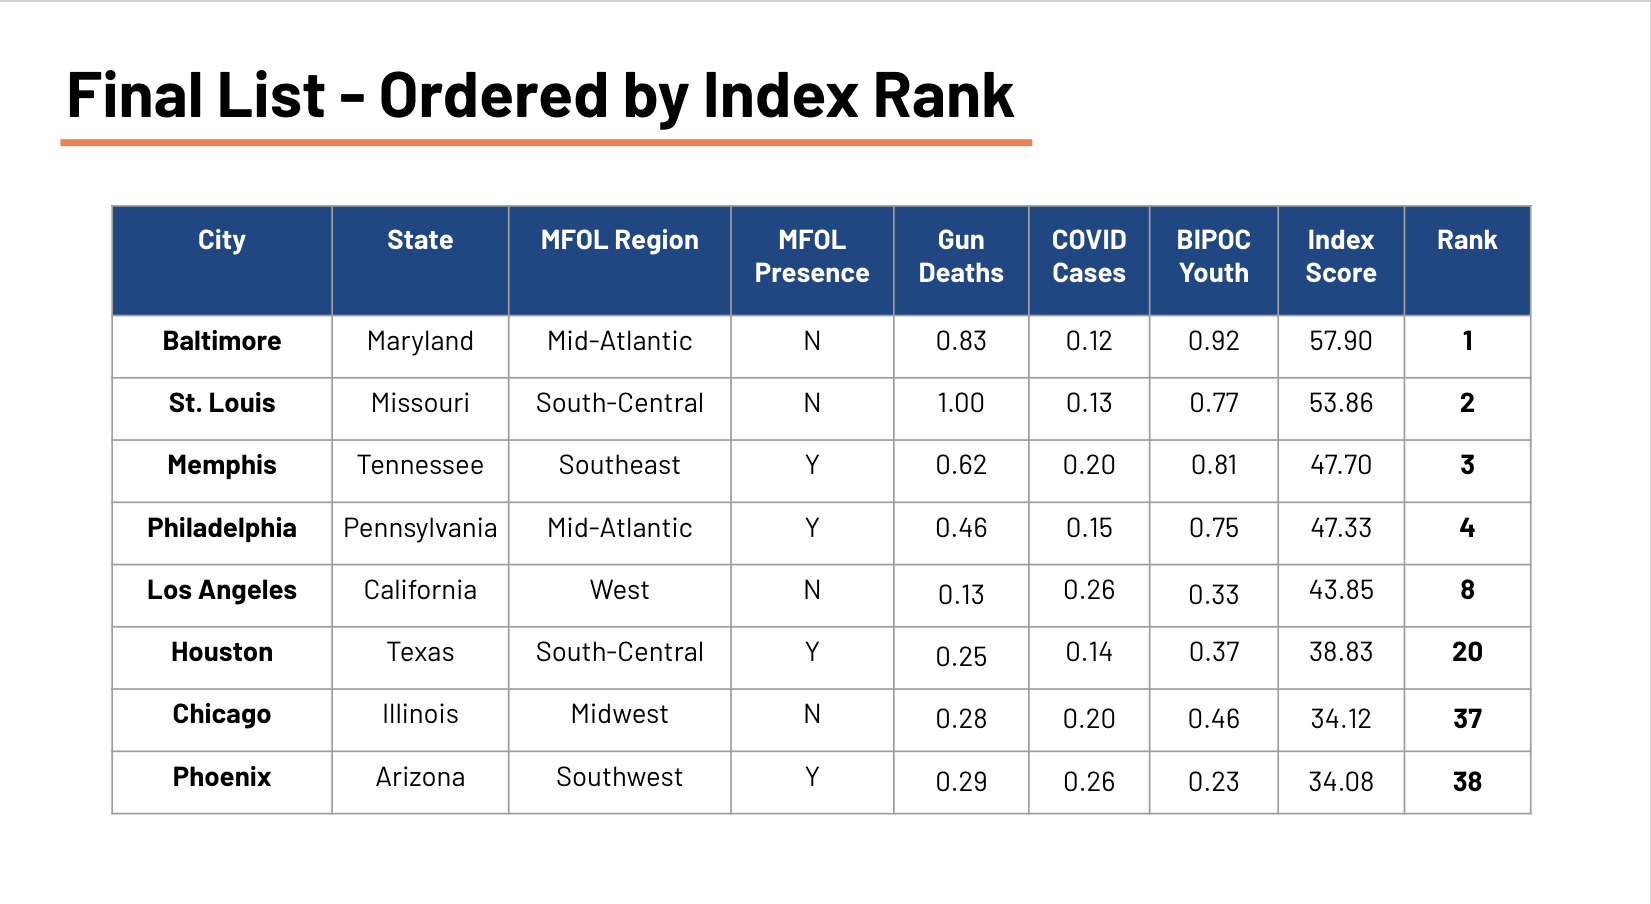

Thanks for taking a read! Drop me a line at tej@marchforourlives.com if you have any feedback, comments, or questions.